In [1]:
# Generate NCI reports for given projects
import os
import sys

user_id = os.environ['USER']

# Insert your local paths here
sys.path.append(f'/home/548/{user_id}/code/nci_resource_tools')
sys.path.append(f'/home/548/{user_id}/code/nci-tools/src/ncitools')


In [2]:
import pandas as pd
import re
import subprocess 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display
import datetime as dt

from nci_account import nci_account
from nci_resource_tools.read_project import retrieve_project_data, create_storage_df
from config import *

In [3]:
print (f'INFO : Executing at {dt.datetime.now()}')

INFO : Executing at 2025-05-05 16:36:32.312570


| NCI Project  | Theme                           | Centre Projectcs                                      | NCI Project Lead  | Resources per year     |
|--------------|---------------------------------|-------------------------------------------------------|-------------------|------------------------|
| [gb02](https://my.nci.org.au/mancini/project/gb02)| Centre-wide Strategic Projects  | All              | gb02 Panel*       | 9 MSUs + 80 TB Storage |
| [fy29](https://my.nci.org.au/mancini/project/fy29)| High-Resolution Modelling       | Modelling        | Bethan White      | 5 MSUs + 20TB Storage  |
| [if69](https://my.nci.org.au/mancini/project/if69)| Circulation Change              | Weather System Dynamics, Variability & Warmer World,  | Chenhui Jin       | 5 MSUs + 20TB Storage  |
| [ng72](https://my.nci.org.au/mancini/project/ng72)| Weather Change                  | Weather Resources & High Impact Weather               | Andrew Brown      | 5 MSUs + 20TB Storage  |
| [su28](https://my.nci.org.au/mancini/project/su28) | Datasets for the Centre         | All                                                   | Sam Green         | 20 TB Storage          |

*gb02 panel: Navid Constantinou, Paul Gregory, Bethan White, Chenhui Jin, Andrew Brown, and Sam Green


In [4]:
SU_df_dict, grant_dict, storage_dict = retrieve_project_data()

## Figures {.tabset}

<Axes: >

Text(-0.35, 4275.0, 'Grant')

Text(0, 0.5, 'kSU')

Text(0.5, 1.0, 'gb02')

<Axes: >

Text(-0.35, 1187.5, 'Grant')

Text(0, 0.5, 'kSU')

Text(0.5, 1.0, 'fy29')

<Axes: >

Text(-0.35, 1187.5, 'Grant')

Text(0, 0.5, 'kSU')

Text(0.5, 1.0, 'if69')

<Axes: >

Text(-0.35, 1187.5, 'Grant')

Text(0, 0.5, 'kSU')

Text(0.5, 1.0, 'ng72')

Text(0.5, 0.98, 'SU usage as of Monday May 2025')

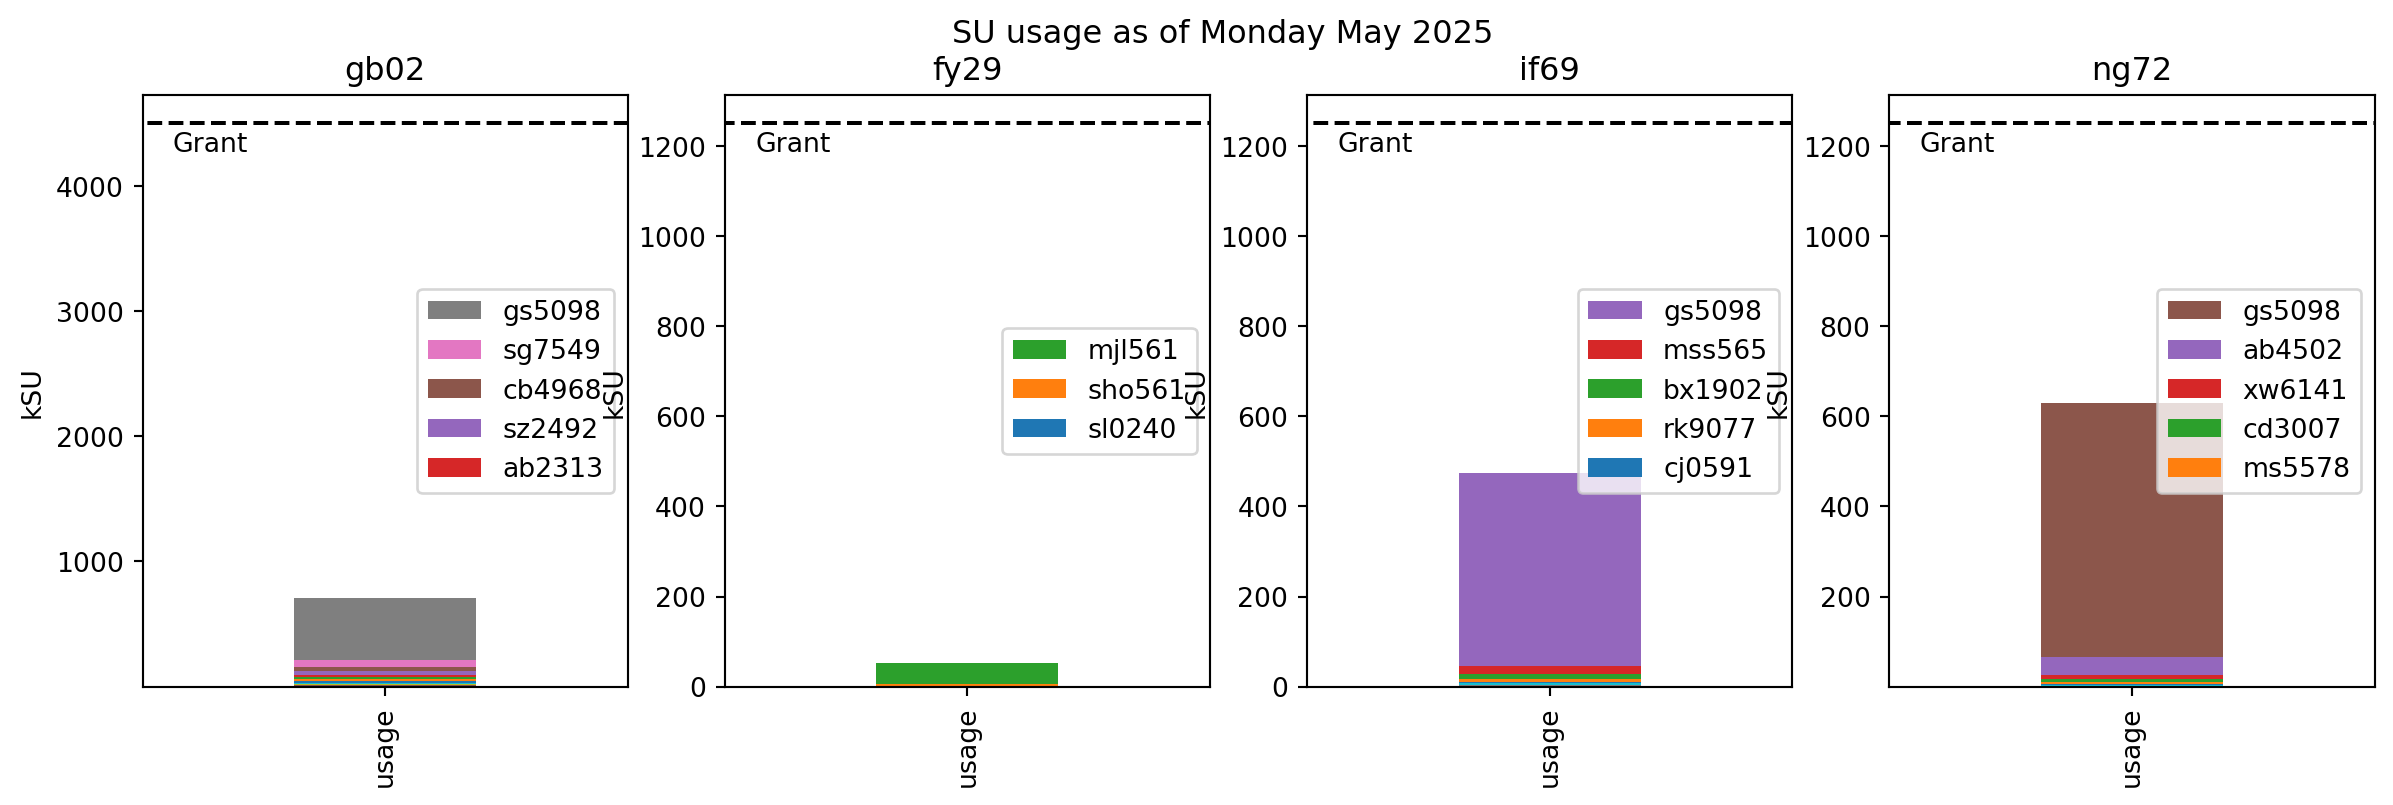

In [5]:
# Plot kSUs for every project
fig,axes = plt.subplots(1,len(grant_dict),figsize=(15,4))

USER_NAMES = 5  #Plot the top five usernames of SU usage

for i,project in enumerate(grant_dict.keys()):
    
    SU_df_dict[project]['usage'].sort_values(ascending=True).to_frame().T.plot.bar(stacked=True,ax=axes[i],width=0.3)
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1],loc=7)
    axes[i].hlines(grant_dict[project],-5,5,linestyles='dashed',color='black')
    axes[i].annotate('Grant',(-0.35,0.95*grant_dict[project]))
    axes[i].yaxis.set_label_text('kSU')
    axes[i].set_title(project)

fig.suptitle(f"SU usage as of {dt.datetime.today().strftime('%A %B %Y')}")

In [6]:
storage_data = create_storage_df(storage_dict)

In [7]:
def convert_size_to_bytes(size_str):
    """
    Converts size strings like '24.6T', '66.1K', '200.1G' to bytes (float).
    """
    size_str = size_str.strip().upper()
    if size_str.endswith('K'):
        return float(size_str[:-1]) * 1024
    elif size_str.endswith('M'):
        return float(size_str[:-1]) * 1024**2
    elif size_str.endswith('G'):
        return float(size_str[:-1]) * 1024**3
    elif size_str.endswith('T'):
        return float(size_str[:-1]) * 1024**4
    elif size_str.endswith('B'):
        return float(size_str[:-1])  # bytes already
    else:
        # If there's no suffix, assume it's in bytes
        return float(size_str)

In [8]:
# Find the largest individual users 
du_dict = {}
headers = ['FILESYSTEM', 'SCAN DATE', 'PROJECT', 'GROUP', 'USER', 'SPACE USED', 'TOTAL SIZE', 'COUNT']

for project in COE_PROJECTS:
    command = f'nci-files-report -S --project {project} --filesystem gdata'
    #print (f' INFO : Executing {command}')
    output_numeric = subprocess.run(command, capture_output=True, shell=True)
    c=output_numeric.stdout.decode('utf-8').splitlines()
    parsed_data = [re.split(r'\s{2,}|\s(?=\d)', line.strip()) for line in c]
    
    # Split the output and create a dictionary
    d = df = pd.DataFrame(parsed_data[1:], columns = headers)
    d = d.set_index('USER')
    d['TOTAL SIZE'] = d['TOTAL SIZE'].apply(convert_size_to_bytes)
    
    du_dict[project] = d

In [9]:
user_storage_numeric=pd.concat(du_dict)['TOTAL SIZE']

<Axes: >

Text(0, 0.5, 'Tb')

[]

Text(0.5, 1.0, 'gb02')

<Axes: >

Text(0, 0.5, 'Tb')

[]

Text(0.5, 1.0, 'fy29')

<Axes: >

Text(0, 0.5, 'Tb')

[]

Text(0.5, 1.0, 'if69')

<Axes: >

Text(0, 0.5, 'Tb')

[]

Text(0.5, 1.0, 'ng72')

<Axes: >

Text(0, 0.5, 'Tb')

[]

Text(0.5, 1.0, 'su28')

Text(0.5, 0.98, 'Leading users of disk storage as of  Monday 05 May 2025')

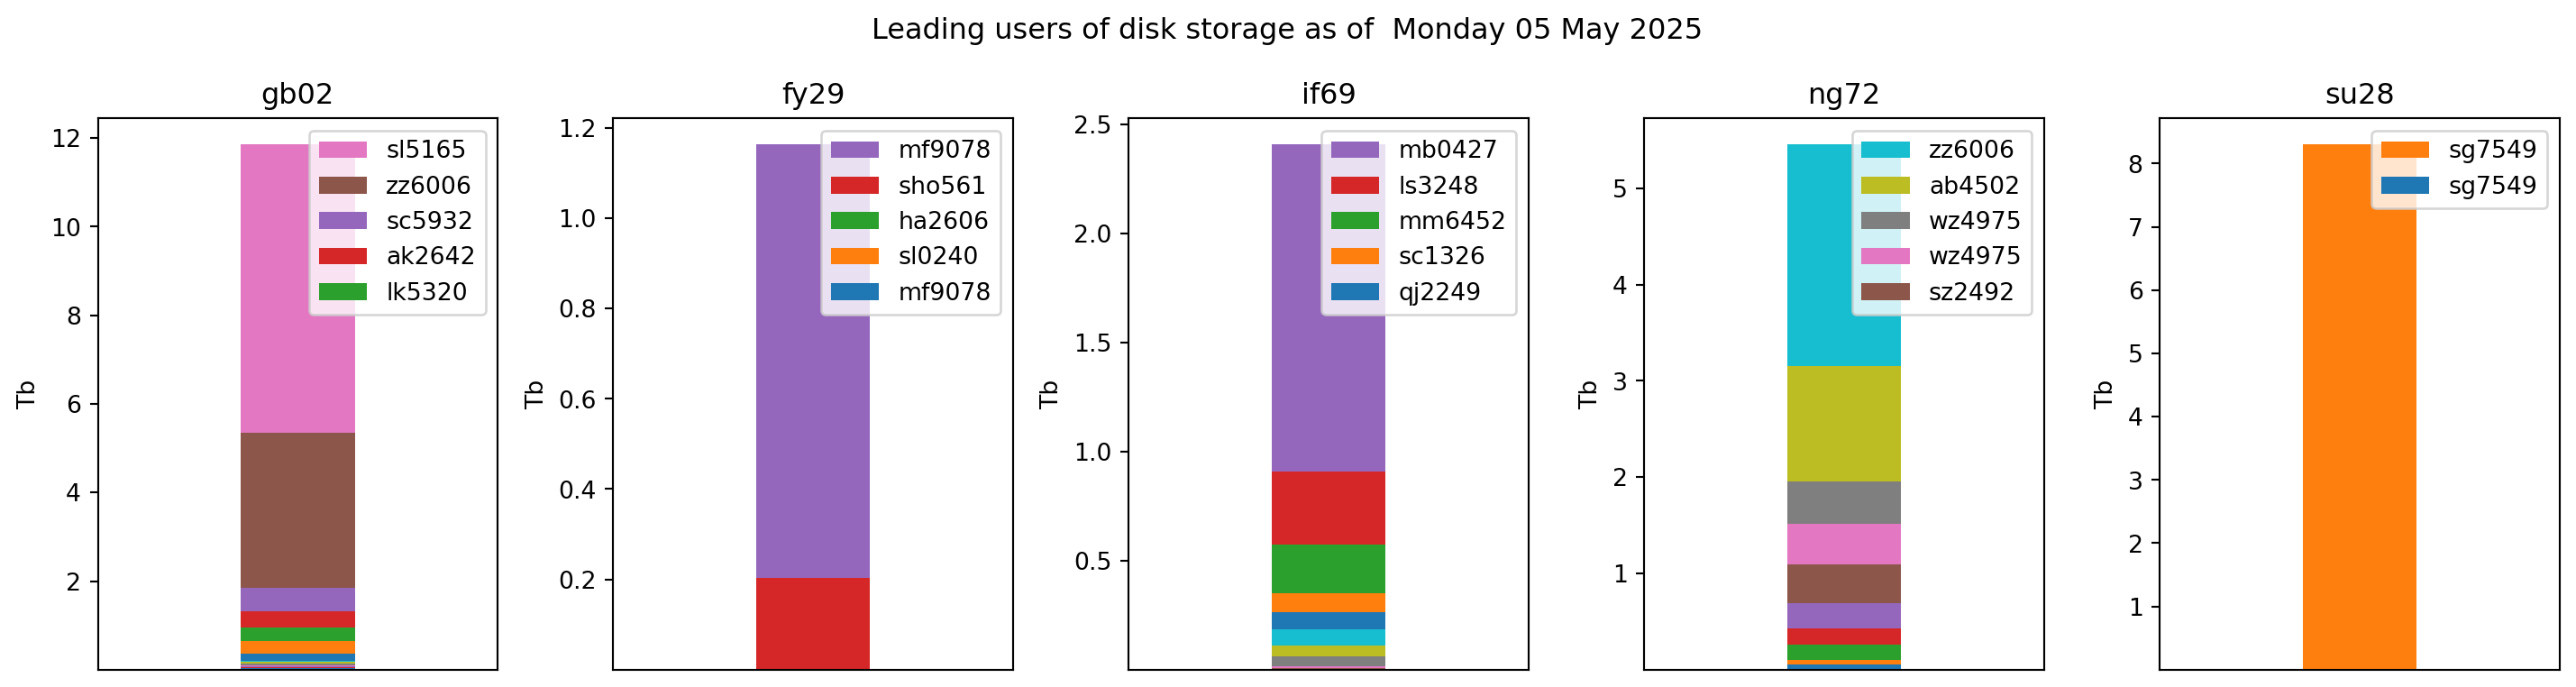

In [10]:
# Plot the five largest users for each project
fig,axes = plt.subplots(1,len(COE_PROJECTS),figsize=(15,4))

for i,project in enumerate(COE_PROJECTS):    
    (user_storage_numeric[project].to_frame().dropna().astype('int').sort_values('TOTAL SIZE')/1024**4).T.plot.bar(stacked=True,ax=axes[i],width=0.2)
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1])
    axes[i].yaxis.set_label_text('Tb')
    axes[i].get_xaxis().set_ticks([])
    axes[i].set_title(project)

fig.suptitle(f"Leading users of disk storage as of  {dt.datetime.today().strftime('%A %d %B %Y')}")
plt.tight_layout()